In [15]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

from scipy.stats import pearsonr

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

#### dBL/dt vector diagram 
- vectors (arrows) indicating BL evolution
- direction: changes in BL, cape and BL, subsat
- length: amplitude of dBL/dt between two MCS phases

In [4]:
def plot_dBLdt_vector_diagram(ax_sub, dBLcape_dt, dBLsubsat_dt, title_string, ntrack, legend_on=True):
        
    ccolors = ['grey','orange','r','limegreen','b']

    for phase, (x_head, y_head) in enumerate(zip(dBLcape_dt, dBLsubsat_dt)):
    
        arrow = FancyArrowPatch((0, 0), (x_head, y_head),mutation_scale=12, color=ccolors[phase],
                               edgecolor='none', alpha=0.5, zorder=2)
        ax_sub.add_patch(arrow)
        
    # ==== set up the coordinate configuration (fixed as defualt) ====    
    # slope to separate dBL_tot/dt > 0 and < 0 
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7),color='grey',linestyle='-',lw=1,zorder=1)
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)-3,color='skyblue',linestyle='--',lw=0.5,zorder=1)
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)-6,color='skyblue',linestyle='--',lw=0.5,zorder=1)
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)-9,color='skyblue',linestyle='--',lw=0.5,zorder=1)
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)+3,color='salmon',linestyle='-',lw=0.5,zorder=1)
    ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)+6,color='salmon',linestyle='-',lw=0.5,zorder=1)
    #ax_sub.plot(np.linspace(-6,6,7),-1*np.linspace(-6,6,7)+9,color='darkred',linestyle='-',lw=0.5)

    #ax_sub.grid(linestyle=':', lw=0.5)
    ax_sub.spines['left'].set_position('center')
    ax_sub.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax_sub.spines['right'].set_color('none')
    ax_sub.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax_sub.xaxis.set_ticks_position('bottom')
    ax_sub.yaxis.set_ticks_position('left')
    ax_sub.set_xticks([-4,-2,2,4])
    ax_sub.set_yticks([-4,-2,2,4])
    ax_sub.set_xlim([-5,5])
    ax_sub.set_ylim([-5,5])
    ax_sub.plot((1), (0), ls="", marker=">", ms=5, color="k",
            transform=ax_sub.get_yaxis_transform(), clip_on=False)
    ax_sub.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=ax_sub.get_xaxis_transform(), clip_on=False)

    ax_sub.text(-2.5,-5.5,'-$\Delta$B$_{L,subsat}$ / $\Delta$t', fontsize=9)
    ax_sub.text(-6,-1.5,'$\Delta$B$_{L,cape}$ / $\Delta$t', fontsize=9, rotation=90)

    ax_sub.tick_params(labelsize=9)
    if legend_on:
        ax_sub.legend(['CCS-Initial','Initial-Grow','Grow-Mature','Mature-Decay','Decay-End'],fontsize=7, frameon=True,
               bbox_to_anchor=[1.1, 1], loc='upper right')
    
    ax_sub.set_title('{} ({})'.format(title, ntrack), fontsize=9.5, loc='left');
    
    #plt.show()    

In [5]:
featstat_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase')
track_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')

In [56]:
%%time
year_list = np.arange(2001,2021)

BCAPErate_SL_list = [] # (< 6H)
BCAPErate_ML_list = [] # (6-12H)
BCAPErate_LL_list = [] # (12-18H)
BCAPErate_UL_list = [] # (18-24H)
BCAPErate_UUL_list = [] # (> 24H)

BSUBrate_SL_list = [] # (< 6H)
BSUBrate_ML_list = [] # (6-12H)
BSUBrate_LL_list = [] # (12-18H)
BSUBrate_UL_list = [] # (18-24H)
BSUBrate_UUL_list = [] # (> 24H)

# hours spent
duration_SL_list = []
duration_ML_list = []
duration_LL_list = []
duration_UL_list = []
duration_UUL_list = []

corr_coeff_cri = 0

for year in year_list:
    
    print('processing year: {}'.format(year))
    data = xr.open_dataset(featstat_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    data = data.sel(mcs_phase=['CCS','Init','Grow','Mature','Decay','End'])
    # for having landsea flag
    data2 = xr.open_dataset(track_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))

    # get correlation coeff. between GPM and ERA-5 from the env. catalogue *** WT 01-29,2025****
    env_dir = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_2D'.format(year))
    ds_gpm = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_precipitation.merged.nc').precipitation # (mm/hr)
    ds_era5 = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_mpr.merged.nc').mtpr*3600 # (mm/hr)
    ds_mask = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc').cloudtracknumber_nomergesplit

    for track in data.tracks.values:

        # get duration info
        mcsduration = data.sel(tracks=track).mcs_duration.values
        # get landsea flag at the MCS initial stage
        landsea_stamps = data2.sel(tracks=track).landsea_flag
        idt_init = data2.idt_mcs_init.sel(tracks=track)
        landsea_flag = landsea_stamps.sel(times=idt_init).values
        corr_coeff_temp = data.sel(tracks=track).corr_coeff_temp
        
        if (corr_coeff_temp >= corr_coeff_cri) and (landsea_flag == 0): # only for HCC tracks, MCSs over oceans (ls=0)
        #if (landsea_flag == 0):
            BL_cape_phase = (340*3/9.8)*data.sel(tracks=track).BL_CAPE_mcs # (deg. K)
            BL_subsat_phase = (340*3/9.8)*data.sel(tracks=track).BL_SUBSAT_mcs
            
            idt_ccs = int(data2.idt_ccs_init.sel(tracks=track))
            idt_init = int(data2.idt_mcs_init.sel(tracks=track))
            idt_grow = int(data2.idt_mcs_grow.sel(tracks=track))
            idt_mature = int(data2.idt_mcs_mature.sel(tracks=track))
            idt_decay = int(data2.idt_mcs_decay.sel(tracks=track))
            idt_end = int(data2.idt_mcs_end.sel(tracks=track))
            idt_phase = [idt_ccs, idt_init, idt_grow, idt_mature, idt_decay, idt_end]

            dBLcape_dt = 24*np.diff(BL_cape_phase)/np.diff(idt_phase) # (K/day)
            dBLsubsat_dt = -24*np.diff(BL_subsat_phase)/np.diff(idt_phase) # (K/day)   
            
            if (mcsduration >= 5) and (mcsduration < 6):
                BCAPErate_SL_list.append(dBLcape_dt)
                BSUBrate_SL_list.append(dBLsubsat_dt)
                duration_SL_list.append(np.diff(idt_phase))

            if (mcsduration >= 6) and (mcsduration < 12):
                BCAPErate_ML_list.append(dBLcape_dt)
                BSUBrate_ML_list.append(dBLsubsat_dt)
                duration_ML_list.append(np.diff(idt_phase))

            if (mcsduration >= 12) and (mcsduration < 18):
                BCAPErate_LL_list.append(dBLcape_dt)
                BSUBrate_LL_list.append(dBLsubsat_dt)
                duration_LL_list.append(np.diff(idt_phase))

            if (mcsduration >= 18) and (mcsduration < 24):
                BCAPErate_UL_list.append(dBLcape_dt)
                BSUBrate_UL_list.append(dBLsubsat_dt) 
                duration_UL_list.append(np.diff(idt_phase))

            if (mcsduration >= 24):
                BCAPErate_UUL_list.append(dBLcape_dt)
                BSUBrate_UUL_list.append(dBLsubsat_dt)
                duration_UUL_list.append(np.diff(idt_phase))

# convert list into numpy array
BCAPErate_SL_oce = np.asarray(BCAPErate_SL_list)
BCAPErate_ML_oce = np.asarray(BCAPErate_ML_list)
BCAPErate_LL_oce = np.asarray(BCAPErate_LL_list)
BCAPErate_UL_oce = np.asarray(BCAPErate_UL_list)
BCAPErate_UUL_oce = np.asarray(BCAPErate_UUL_list)

BSUBrate_SL_oce = np.asarray(BSUBrate_SL_list)
BSUBrate_ML_oce = np.asarray(BSUBrate_ML_list)
BSUBrate_LL_oce = np.asarray(BSUBrate_LL_list)
BSUBrate_UL_oce = np.asarray(BSUBrate_UL_list)
BSUBrate_UUL_oce = np.asarray(BSUBrate_UUL_list)

duration_SL_oce = np.asarray(duration_SL_list)
duration_ML_oce = np.asarray(duration_ML_list)
duration_LL_oce = np.asarray(duration_LL_list)
duration_UL_oce = np.asarray(duration_UL_list)
duration_UUL_oce = np.asarray(duration_UUL_list)

processing year: 2001
processing year: 2002
processing year: 2003
processing year: 2004
processing year: 2005
processing year: 2006
processing year: 2007
processing year: 2008
processing year: 2009
processing year: 2010
processing year: 2011
processing year: 2012
processing year: 2013
processing year: 2014
processing year: 2015
processing year: 2016
processing year: 2017
processing year: 2018
processing year: 2019
processing year: 2020
CPU times: user 9min 16s, sys: 3.81 s, total: 9min 20s
Wall time: 9min 22s


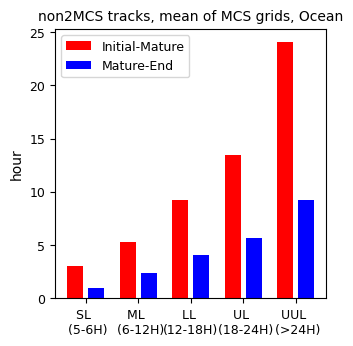

In [13]:
# times spent in the init-mature and the mature-end over oceans and land
fig = plt.figure(figsize=(3.5,3.5))

for n,duration in enumerate([duration_SL_oce, duration_ML_oce, duration_LL_oce,
                     duration_UL_oce, duration_UUL_oce]):
    hours_i2m = np.sum(duration[:,1:4],axis=1)
    hours_m2e = np.sum(duration[:,4:7],axis=1)
    
    plt.bar(n-0.2,np.nanmean(hours_i2m),color='r',width=0.3)
    plt.bar(n+0.2,np.nanmean(hours_m2e),color='b',width=0.3)
    
plt.xticks(ticks=[0,1,2,3,4],labels=['SL \n (5-6H)','ML \n (6-12H)','LL \n(12-18H)','UL \n (18-24H)','UUL \n (>24H)'],
          fontsize=10)
plt.legend(['Initial-Mature','Mature-End'],fontsize=9)
plt.ylabel('hour',fontsize=10)
plt.tick_params(labelsize=9)
plt.title('non2MCS tracks, mean of MCS grids, Ocean',fontsize=10);

In [ ]:
# check effect of temporal filtering on the result
# correlation between GPM and ERA5 > 0


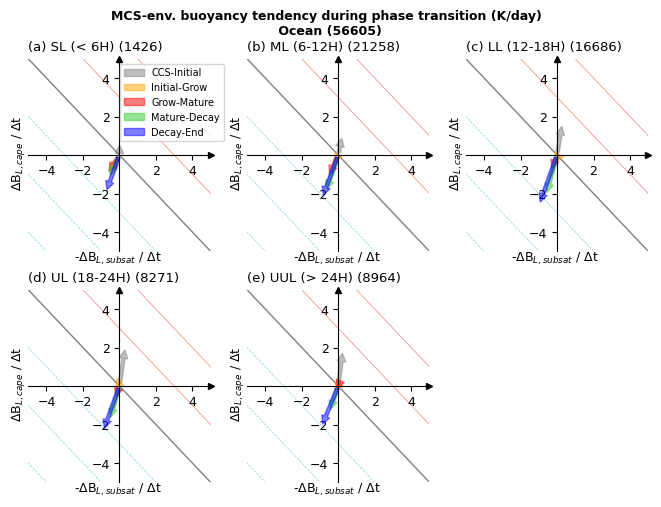

In [14]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,5.5))

tmp1 = [np.nanmean(BCAPErate_SL_oce,axis=0),np.nanmean(BCAPErate_ML_oce,axis=0),np.nanmean(BCAPErate_LL_oce,axis=0),
        np.nanmean(BCAPErate_UL_oce,axis=0),np.nanmean(BCAPErate_UUL_oce,axis=0)]
tmp2 = [np.nanmean(BSUBrate_SL_oce,axis=0),np.nanmean(BSUBrate_ML_oce,axis=0),np.nanmean(BSUBrate_LL_oce,axis=0),
        np.nanmean(BSUBrate_UL_oce,axis=0),np.nanmean(BSUBrate_UUL_oce,axis=0)]
titles = ['(a) SL (< 6H)','(b) ML (6-12H)','(c) LL (12-18H)','(d) UL (18-24H)','(e) UUL (> 24H)']
numtracks = [BSUBrate_SL_oce.shape[0], BSUBrate_ML_oce.shape[0], BSUBrate_LL_oce.shape[0], 
             BSUBrate_UL_oce.shape[0], BSUBrate_UUL_oce.shape[0]]
total_tracks = np.sum(numtracks)

for n,(ax_sub, dBCAPE_dt,dBSUB_dt,title,ntrack) in enumerate(zip([ax1,ax2,ax3,ax4,ax5],tmp1,tmp2,titles,numtracks)):
    if n == 0:
        plot_dBLdt_vector_diagram(ax_sub, dBCAPE_dt, dBSUB_dt, title, ntrack, legend_on=True)
    else:
        # put legend on the right 
        plot_dBLdt_vector_diagram(ax_sub, dBCAPE_dt, dBSUB_dt, title, ntrack, legend_on=False)

# hide the blank axes
ax6.set_xticks([])
ax6.set_yticks([])
ax6.spines['right'].set_color('none')
ax6.spines['top'].set_color('none')
ax6.spines['left'].set_color('none')
ax6.spines['bottom'].set_color('none')
    
fig.suptitle('MCS-env. buoyancy tendency during phase transition (K/day) \n Ocean ({})'.format(total_tracks), fontsize=9, y=0.97,
            fontweight='bold');

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLtendency_vectordiagram_MCSmean_NonTemp_ocean.png',dpi=300,
#         bbox_inches='tight',transparent=False)

In [ ]:
%%time
year_list = np.arange(2001,2021)

BCAPErate_SL_list = [] # (< 6H)
BCAPErate_ML_list = [] # (6-12H)
BCAPErate_LL_list = [] # (12-18H)
BCAPErate_UL_list = [] # (18-24H)
BCAPErate_UUL_list = [] # (> 24H)

BSUBrate_SL_list = [] # (< 6H)
BSUBrate_ML_list = [] # (6-12H)
BSUBrate_LL_list = [] # (12-18H)
BSUBrate_UL_list = [] # (18-24H)
BSUBrate_UUL_list = [] # (> 24H)

# hours spent
duration_SL_list = []
duration_ML_list = []
duration_LL_list = []
duration_UL_list = []
duration_UUL_list = []

corr_coeff_cri = -999

for year in year_list:
    
    print('processing year: {}'.format(year))
    data = xr.open_dataset(featstat_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    data = data.sel(mcs_phase=['CCS','Init','Grow','Mature','Decay','End'])
    # for having landsea flag
    data2 = xr.open_dataset(track_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

    for track in data.tracks.values:

        # get duration info
        mcsduration = data.sel(tracks=track).mcs_duration.values
        # get landsea flag at the MCS initial stage
        landsea_stamps = data2.sel(tracks=track).landsea_flag
        idt_init = data2.idt_mcs_init.sel(tracks=track)
        landsea_flag = landsea_stamps.sel(times=idt_init).values
        
        # get correlation coeff. between GPM and ERA-5
        corr_coeff_temp = data.sel(tracks=track).corr_coeff_temp
        
        if (corr_coeff_temp >= corr_coeff_cri) and (landsea_flag == 1): # only for HCC tracks, MCSs over land (ls=1)

            BL_cape_phase = data.sel(tracks=track).BL_CAPE_mcs
            BL_subsat_phase = data.sel(tracks=track).BL_SUBSAT_mcs
            
            idt_ccs = int(data2.idt_ccs_init.sel(tracks=track))
            idt_init = int(data2.idt_mcs_init.sel(tracks=track))
            idt_grow = int(data2.idt_mcs_grow.sel(tracks=track))
            idt_mature = int(data2.idt_mcs_mature.sel(tracks=track))
            idt_decay = int(data2.idt_mcs_decay.sel(tracks=track))
            idt_end = int(data2.idt_mcs_end.sel(tracks=track))
            idt_phase = [idt_ccs, idt_init, idt_grow, idt_mature, idt_decay, idt_end]

            dBLcape_dt = 24*np.diff(BL_cape_phase)/np.diff(idt_phase) # (K/day)
            dBLsubsat_dt = -24*np.diff(BL_subsat_phase)/np.diff(idt_phase) # (K/day)   
            
            if (mcsduration >= 5) and (mcsduration < 6):
                BCAPErate_SL_list.append(dBLcape_dt)
                BSUBrate_SL_list.append(dBLsubsat_dt)
                duration_SL_list.append(np.diff(idt_phase))

            if (mcsduration >= 6) and (mcsduration < 12):
                BCAPErate_ML_list.append(dBLcape_dt)
                BSUBrate_ML_list.append(dBLsubsat_dt)
                duration_ML_list.append(np.diff(idt_phase))

            if (mcsduration >= 12) and (mcsduration < 18):
                BCAPErate_LL_list.append(dBLcape_dt)
                BSUBrate_LL_list.append(dBLsubsat_dt)
                duration_LL_list.append(np.diff(idt_phase))

            if (mcsduration >= 18) and (mcsduration < 24):
                BCAPErate_UL_list.append(dBLcape_dt)
                BSUBrate_UL_list.append(dBLsubsat_dt) 
                duration_UL_list.append(np.diff(idt_phase))

            if (mcsduration >= 24):
                BCAPErate_UUL_list.append(dBLcape_dt)
                BSUBrate_UUL_list.append(dBLsubsat_dt)
                duration_UUL_list.append(np.diff(idt_phase))

# convert list into numpy array
BCAPErate_SL_lnd = np.asarray(BCAPErate_SL_list)
BCAPErate_ML_lnd = np.asarray(BCAPErate_ML_list)
BCAPErate_LL_lnd = np.asarray(BCAPErate_LL_list)
BCAPErate_UL_lnd = np.asarray(BCAPErate_UL_list)
BCAPErate_UUL_lnd = np.asarray(BCAPErate_UUL_list)

BSUBrate_SL_lnd = np.asarray(BSUBrate_SL_list)
BSUBrate_ML_lnd = np.asarray(BSUBrate_ML_list)
BSUBrate_LL_lnd = np.asarray(BSUBrate_LL_list)
BSUBrate_UL_lnd = np.asarray(BSUBrate_UL_list)
BSUBrate_UUL_lnd = np.asarray(BSUBrate_UUL_list)

duration_SL_lnd = np.asarray(duration_SL_list)
duration_ML_lnd = np.asarray(duration_ML_list)
duration_LL_lnd = np.asarray(duration_LL_list)
duration_UL_lnd = np.asarray(duration_UL_list)
duration_UUL_lnd = np.asarray(duration_UUL_list)

In [ ]:
# times spent in the init-mature and the mature-end over oceans and land
fig = plt.figure(figsize=(3.5,3.5))

for n,duration in enumerate([duration_SL_lnd, duration_ML_lnd, duration_LL_lnd,
                     duration_UL_lnd, duration_UUL_lnd]):
    hours_i2m = np.sum(duration[:,1:3],axis=1)
    hours_m2e = np.sum(duration[:,4:6],axis=1)
    
    plt.bar(n-0.2,np.nanmean(hours_i2m),color='r',width=0.3)
    plt.bar(n+0.2,np.nanmean(hours_m2e),color='b',width=0.3)
    
plt.xticks(ticks=[0,1,2,3,4],labels=['SL \n (5-6H)','ML \n (6-12H)','LL \n(12-18H)','UL \n (18-24H)','UUL \n (>24H)'],
          fontsize=10)
plt.legend(['Initial-Mature','Mature-End'],fontsize=9)
plt.ylabel('hour',fontsize=10)
plt.tick_params(labelsize=9)
plt.title('non2MCS tracks, Land')

In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(8,5.5))

tmp1 = [np.nanmean(BCAPErate_SL_lnd,axis=0),np.nanmean(BCAPErate_ML_lnd,axis=0),np.nanmean(BCAPErate_LL_lnd,axis=0),
        np.nanmean(BCAPErate_UL_lnd,axis=0),np.nanmean(BCAPErate_UUL_lnd,axis=0)]
tmp2 = [np.nanmean(BSUBrate_SL_lnd,axis=0),np.nanmean(BSUBrate_ML_lnd,axis=0),np.nanmean(BSUBrate_LL_lnd,axis=0),
        np.nanmean(BSUBrate_UL_lnd,axis=0),np.nanmean(BSUBrate_UUL_lnd,axis=0)]
titles = ['(a) SL (< 6H)','(b) ML (6-12H)','(c) LL (12-18H)','(d) UL (18-24H)','(e) UUL (> 24H)']
numtracks = [BSUBrate_SL_lnd.shape[0], BSUBrate_ML_lnd.shape[0], BSUBrate_LL_lnd.shape[0], 
             BSUBrate_UL_lnd.shape[0], BSUBrate_UUL_lnd.shape[0]]
total_tracks = np.sum(numtracks)

for n,(ax_sub, dBCAPE_dt,dBSUB_dt,title,ntrack) in enumerate(zip([ax1,ax2,ax3,ax4,ax5],tmp1,tmp2,titles,numtracks)):
    if n == 0:
        plot_dBLdt_vector_diagram(ax_sub, dBCAPE_dt, dBSUB_dt, title, ntrack, legend_on=True)
    else:
        # put legend on the right 
        plot_dBLdt_vector_diagram(ax_sub, dBCAPE_dt, dBSUB_dt, title, ntrack, legend_on=False)

# hide the blank axes
ax6.set_xticks([])
ax6.set_yticks([])
ax6.spines['right'].set_color('none')
ax6.spines['top'].set_color('none')
ax6.spines['left'].set_color('none')
ax6.spines['bottom'].set_color('none')
    
fig.suptitle('MCS-env. buoyancy tendency during phase transition (K/day) \n Land ({})'.format(total_tracks), fontsize=9, y=0.97,
            fontweight='bold');

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/BLtendency_vectordiagram_MCSland.png',dpi=500,
#           bbox_inches='tight',transparent=False)

In [53]:
year = 2015

# get correlation coeff. between GPM and ERA-5 from the env. catalogue
env_dir = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_2D'.format(year))
ds_gpm = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_precipitation.merged.nc').precipitation # (mm/hr)
ds_era5 = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_mpr.merged.nc').mtpr*3600 # (mm/hr)
ds_mask = xr.open_dataset(env_dir / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc').cloudtracknumber_nomergesplit

# correlation between the mcs-area averaged values
corr_temp = []
for track in ds_gpm.tracks:
    tmp1 = ds_gpm.sel(tracks=track, time=[1,2,3,4,5])
    tmp2 = ds_era5.sel(tracks=track, time=[1,2,3,4,5])
    tmp3 = ds_mask.sel(tracks=track, time=[1,2,3,4,5])
    mcs_gpm = tmp1.where(tmp3 == track+1).mean(('x','y'))
    mcs_era5 = tmp2.where(tmp3 == track+1).mean(('x','y'))
    try:
        corr_temp.append(pearsonr(mcs_gpm[~np.isnan(mcs_gpm)], mcs_era5[~np.isnan(mcs_gpm)]).statistic)
    except:
        corr_temp.append(np.NaN)

In [54]:
len(corr_temp)

5195

In [55]:
ds_era5

<xarray.DataArray 'mtpr' (tracks: 5195, time: 6, y: 41, x: 41)> Size: 210MB
array([[[[ 1.17151886e-01,  1.17151886e-01,  9.83300582e-02, ...,
           6.89128740e-03,  6.95589324e-03,  9.47552081e-03],
         [ 7.59979859e-02,  5.55260107e-02,  4.49559614e-02, ...,
           1.72282191e-04,  2.15891123e-04,  1.91663939e-03],
         [ 2.82973517e-02,  1.76729225e-02,  1.37998033e-02, ...,
           1.63668080e-03,  1.63883436e-03,  1.72282185e-03],
         ...,
         [-6.24500451e-15, -6.24500451e-15, -6.24500451e-15, ...,
          -6.24500451e-15, -6.24500451e-15, -6.24500451e-15],
         [ 2.15352738e-05,  5.38381812e-07, -6.24500451e-15, ...,
          -6.24500451e-15, -6.24500451e-15, -6.24500451e-15],
         [ 8.61410925e-04,  2.15352738e-05, -6.24500451e-15, ...,
          -6.24500451e-15, -6.24500451e-15, -6.24500451e-15]],

        [[ 4.30705473e-02,  3.97110432e-02,  3.88065651e-02, ...,
           4.19076420e-02,  3.54039893e-02,  5.16846590e-03],
         [ 8.67440775e-02,  8.74789730e-02,  6.83281943e-02, ...,
           8.35654810e-02,  5.46161458e-02,  2.02862266e-02],
         [ 1.16505831e-01,  1.18941471e-01,  1.00918598e-01, ...,
           7.05581754e-02,  5.43722585e-02,  5.50441593e-02],
...
           2.71139611e-02,  2.42757834e-02,  2.18896717e-02],
         [ 3.09310574e-03,  1.13450708e-02,  1.42367836e-02, ...,
           2.79586166e-02,  2.19228119e-02,  2.45409049e-02],
         [ 1.76748894e-02,  3.75591405e-02,  4.45271283e-02, ...,
           1.80827733e-02,  2.58665215e-02,  2.71921381e-02]],

        [[ 1.38679907e-01,  1.45307988e-01,  8.99379998e-02, ...,
           6.56418204e-01,  6.12978816e-01,  1.27803057e-01],
         [ 2.99793333e-02,  2.75600813e-02,  2.86282226e-02, ...,
           6.37329340e-01,  7.31754005e-01,  1.22500584e-01],
         [ 2.20256336e-02,  2.31524054e-02,  1.96293257e-02, ...,
           2.33981565e-01,  2.01357797e-01,  1.43030658e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  6.45813343e-05, ...,
           1.67401601e-02,  1.84855554e-02,  2.35891808e-02],
         [ 3.39901744e-05,  3.39901744e-05,  1.29332615e-03, ...,
           2.43862495e-02,  3.37870829e-02,  3.64714563e-02],
         [ 1.35960686e-03,  1.35960686e-03,  1.35960686e-03, ...,
           5.81231937e-02,  1.30590245e-01,  1.86266154e-01]]]],
      dtype=float32)
Coordinates:
    lon      (tracks, time, x) float64 10MB ...
    lat      (tracks, time, y) float64 10MB ...
  * x        (x) int64 328B 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * y        (y) int64 328B 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * time     (time) int64 48B 0 1 2 3 4 5
  * tracks   (tracks) int64 42kB 38 47 57 63 67 ... 32603 32622 32634 32649